# Vision-Language Model

* 4bit quantised idefics-80b VLM
* 4bit quantised idefics-80b VLM with instruction-tuning

*use `idefics_colab` conda env*

In [1]:
import torch
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig
import torchvision.transforms as transforms
from sidemethods import load_richardson_data, logprobs_from_prompt
from tqdm import tqdm
import itertools
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns


_, richardson_data, richardson_normed = load_richardson_data()
action_words = richardson_normed.keys()

KeyboardInterrupt: 

In [2]:
gpu = 3 # "all" or INT: 0,1,2,3
quantised = True

model_name = "idefics/idefics-80b"

In [4]:
# Check available gpu (gpustat -i)
if gpu == "all":
    device_map = "auto"
elif isinstance(gpu, int):
    device_map = {"" : gpu}


# checkpoint = "HuggingFaceM4/tiny-random-idefics"
local_path = "/mounts/data/corp/huggingface/"
checkpoint = local_path+model_name

# Here we skip some special modules that can't be quantized properly
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

# Idefics 80 non-instruct

In [5]:
processor = AutoProcessor.from_pretrained(checkpoint, use_auth_token=True)
# Simply take-off the quantization_config arg if you want to load the original model
if quantised:
    model = IdeficsForVisionText2Text.from_pretrained(checkpoint,quantization_config=bnb_config, device_map=device_map) 
else:
    model = IdeficsForVisionText2Text.from_pretrained(checkpoint, device_map=device_map) 


/mounts/work/pwicke/miniconda3/envs/idefics_colab/lib/python3.10/site-packages/transformers/models/auto/processing_auto.py:206: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


In [7]:
def check_inference(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    if gpu == "all":
        inputs = processor(prompts, return_tensors="pt")
    else:
        inputs = processor(prompts, return_tensors="pt").to(device_map[""])
        
    generated_ids = model.generate(**inputs, 
                                   eos_token_id=[eos_token_id], 
                                   bad_words_ids=bad_words_ids, 
                                   max_new_tokens=max_new_tokens, 
                                   early_stopping=False,
                                   num_beams=1, 
                                   )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def check_logprobs(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    if gpu == "all":
        inputs = processor(prompts, return_tensors="pt")
    else:
        inputs = processor(prompts, return_tensors="pt").to(device_map[""])

    input_ids = inputs["input_ids"]
    output = model(input_ids=input_ids)
 
    shift_labels = input_ids[..., 1:].contiguous()
    shift_logits = output.logits[..., :-1, :].contiguous()
    log_probs = []
    log_probs.append((tokenizer.decode(input_ids[0].tolist()[0]), None))
    for idx, (label_id, logit) in enumerate(zip(shift_labels[0].tolist(), shift_logits[0])):
        logit = logit.type(torch.FloatTensor) # device_map="auto" fpr model initialization
        logprob = F.log_softmax(logit, dim=0)[label_id].item()
        log_probs.append((tokenizer.decode(label_id), float(logprob)))
    return log_probs
  

## Testing Prompts for Experiment

In [51]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Which one of the images (A-D) describes the event 'arrow down' best? Answer: Image "
]
print(check_inference(model, processor, prompts, max_new_tokens=2))


Image A: Image B: Image C: Image D: Question: Which one of the images (A-D) describes the event 'arrow down' best? Answer: Image A



In [14]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Give a one sentence description for each image. The description should focus on the differences. Answer:"
]
check_inference(model, processor, prompts, max_new_tokens=60)


'Image A: Image B: Image C: Image D: Question: Give a one sentence description for each image. The description should focus on the differences. Answer:\n\nImage A: The object is moving to the right.\n\nImage B: The object is moving to the left.\n\nImage C: The object is moving up and down.\n\nImage D: The object is moving up and down.\n\nQuestion: What is the difference'

## Prompt Search

In [54]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image "
]
check_inference(model, processor, prompts, max_new_tokens=5)


"Image A: Image B: Image C: Image D: Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image A\n\nQuestion:"

# Run experiment

 Initial experiments show that encoding with A, B, C, D was heavily favouring the selection of image A no matter the order or image. This suggests that the letter A has some primary features due to its alphabetical order. This bias can potentially be mitigated by selecting a set of codes that are designed to have minimal suggestion of acronyms or patterns, providing a more neutral set of labels for your image classification task

In [7]:
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'FQHL', 3:'VMBR'} # up, down, left, right

images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

with open("results/VISUAL_"+model_name.split("/")[1]+"_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words):

        if action_word == 0:
            continue

        for choice_list in list(itertools.permutations(options)):

            ### PROMPTS DEFINED HERE
            prompts = [
                        # "Instruction: provide an answer to the question. Use the image to answer.\n",
                        f"Image {options[choice_list[0]]}:",
                        images[choice_list[0]],
                        f"Image {options[choice_list[1]]}:",
                        images[choice_list[1]],
                        f"Image {options[choice_list[2]]}:",
                        images[choice_list[2]],
                        f"Image {options[choice_list[3]]}:",
                        images[choice_list[3]],
                        "The image that best describes the event '"+action_word+"' is the Image "
                    ]

            new_token_num = 4
            generated_answer = check_inference(model, processor, prompts, max_new_tokens=new_token_num) 
            #print("Full answer:", generated_answer)
            generated_answer = generated_answer[-new_token_num-1:]
            #print("Retrieved answer:", generated_answer)
            #print("-------")

            counted = False
            if action_word not in model_choices.keys():
                model_choices[action_word] = [0,0,0,0]

            targets = list(options.values())
            finding = find_earliest_string(targets, generated_answer)
            if finding:
                model_choices[action_word][targets.index(finding)]+=1
                counted = True

            if sum(model_choices[action_word]) > 24:
                print("Too many arrows in response.")
                
            promptstring = prompts[0]+prompts[2]+prompts[4]+prompts[6]
            promptstring = promptstring.replace("Image ","").replace(":",",")
            f_out.write(action_word+"\t"+promptstring+"\t"+generated_answer+"\n")
            f_out.write(action_word+"\t"+", ".join(targets)+"\t"+generated_answer+"\n")

print(model_choices)
# 30min on llama 70b
# 30min on llama 70b chat
# 5min on llama 13b
# 5min on llama 13b chat

  0%|          | 0/30 [00:00<?, ?it/s]/mounts/work/pwicke/miniconda3/envs/idefics_colab/lib/python3.10/site-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 30/30 [14:30<00:00, 29.02s/it]

{'fled': [0, 1, 22, 1], 'pointed at': [4, 2, 10, 8], 'pulled': [4, 1, 15, 4], 'pushed': [1, 0, 16, 7], 'walked': [6, 2, 4, 12], 'hunted': [4, 2, 12, 6], 'impacted': [4, 2, 11, 7], 'perched': [5, 2, 11, 6], 'showed': [6, 2, 9, 7], 'smashed': [6, 2, 10, 6], 'bombed': [6, 2, 10, 6], 'flew': [0, 0, 23, 1], 'floated': [0, 0, 23, 1], 'lifted': [3, 0, 14, 7], 'sank': [2, 2, 13, 7], 'argued with': [5, 3, 8, 8], 'gave to': [1, 2, 11, 10], 'offended': [6, 2, 9, 7], 'rushed': [6, 2, 9, 7], 'warned': [6, 2, 9, 7], 'owned': [6, 2, 9, 7], 'regretted': [6, 3, 8, 7], 'rested': [4, 2, 11, 7], 'tempted': [4, 3, 10, 7], 'wanted': [6, 2, 8, 8], 'hoped': [4, 2, 11, 7], 'increased': [4, 2, 11, 7], 'obeyed': [5, 2, 11, 6], 'respected': [5, 2, 10, 7], 'succeeded': [6, 2, 7, 9]}


### Storing Experimental Results

In [8]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

### Loading Experimental Results

In [9]:
model_choices = dict()
with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity (within and out of constructs)

In [10]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9947973813777202, 'pointed at': 0.617013259018214, 'pulled': 0.981283502819517, 'pushed': 0.41553980275330443, 'walked': 0.9481120340336295, 'hunted': 0.5018221200931852, 'impacted': 0.5642265005215424, 'perched': 0.3002553793111895, 'showed': 0.7354711514643493, 'smashed': 0.35211145993834075, 'bombed': 0.2247468820561354, 'flew': 0.2513160541645882, 'floated': 0.12051678358501672, 'lifted': 0.21400157779741008, 'sank': 0.22535398197896905, 'argued with': 0.8300099701500993, 'gave to': 0.69015593602791, 'offended': 0.8291628168300089, 'rushed': 0.8444515654535936, 'warned': 0.6848846451704085, 'owned': 0.5580154772583445, 'regretted': 0.9252958987055139, 'rested': 0.8103697694914058, 'tempted': 0.9964084449717763, 'wanted': 0.8523197573970023, 'hoped': 0.6426919592775157, 'increased': 0.4608803111542396, 'obeyed': 0.9366696791202344, 'respected': 0.7403276559259524, 'succeeded': 0.6884516169750463}
{'Horizontal': 0.6017, 'Neutral': 0.4204, 'Vertical': 0.1621, 'Horizon.': 0.

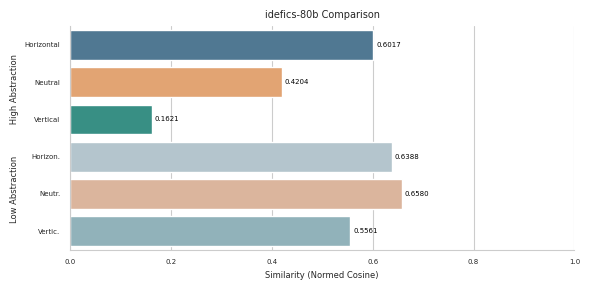

In [11]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name.split("/")[1]+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_CosSim.png")
plt.show()


In [12]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/VISUAL_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/VISUAL_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+str(average_sim)+"\n")

Average similarity between human choice and model choices is:  0.50618


In [13]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

## Spearman R

In [14]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [15]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/VISUAL_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/VISUAL_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (-0.18337236411484695, 0.33207026745070445),
 'D:◯↓▢': (0.10707821760303377, 0.5733028052390973),
 'B:◯←▢ ': (-0.1803347073039501, 0.34027966882624217),
 'A:◯→▢': (0.567762852501793, 0.0010660592299138749)}

## Visualization of Choice Distribution

/tmp/ipykernel_591582/279255179.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


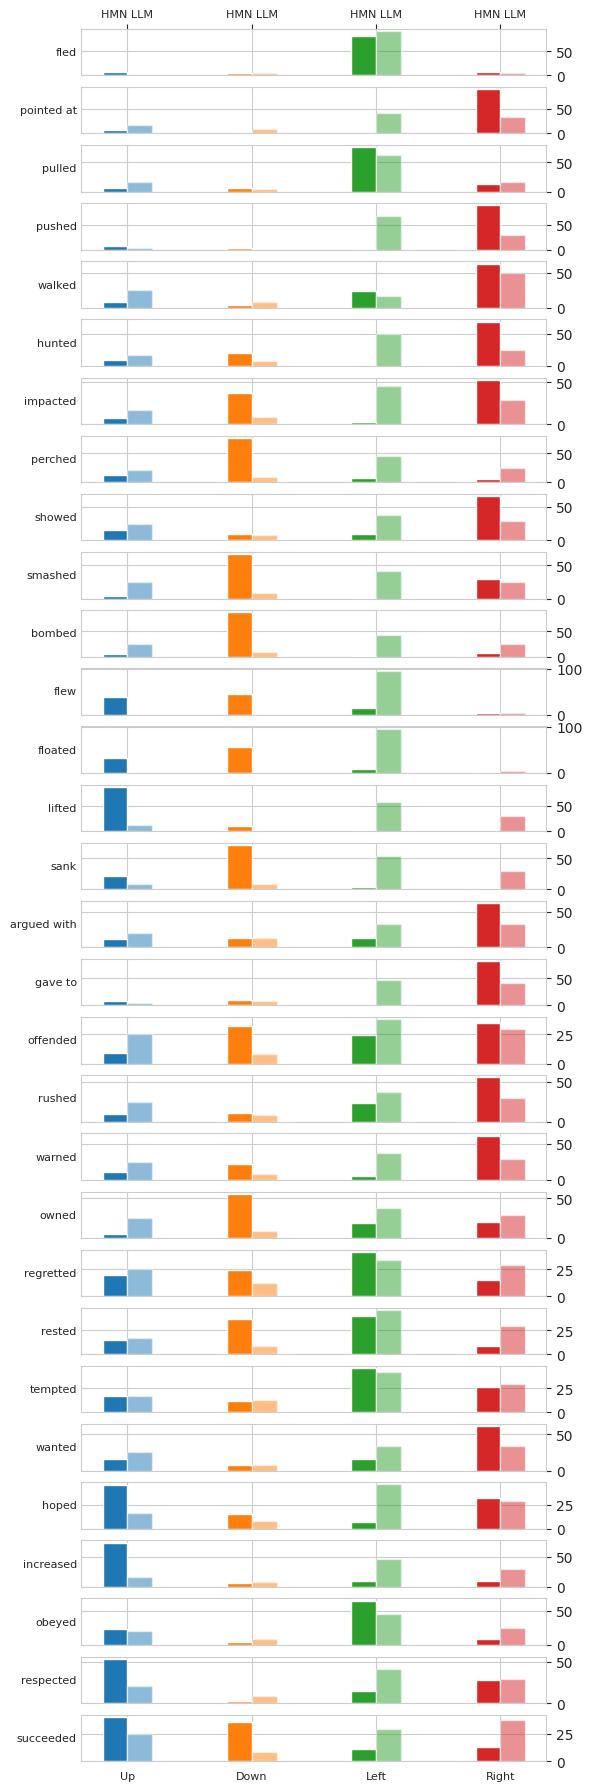

In [86]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["Up", 'Down', 'Left', 'Right'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_Choices.png")
plt.show()


# Instruct Model

In [5]:
# stored in cache, hence
checkpoint = "HuggingFaceM4/idefics-80b-instruct"
model_name = "idefics/idefics-80b-instruct"

processor = AutoProcessor.from_pretrained(checkpoint, use_auth_token=True)
model = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=bnb_config ,device_map=device_map,cache_dir="/mounts/data/corp/huggingface/hub/")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 17/17 [05:49<00:00, 20.54s/it]


# Run experiment

 Initial experiments show that encoding with A, B, C, D was heavily favouring the selection of image A no matter the order or image. This suggests that the letter A has some primary features due to its alphabetical order. This bias can potentially be mitigated by selecting a set of codes that are designed to have minimal suggestion of acronyms or patterns, providing a more neutral set of labels for your image classification task

In [ ]:
prompts = [
            "Instruction: You are given four images and are supposed to select one to answer a question.\n",
            f"Image {options[choice_list[0]]}:",
            images[choice_list[0]],
            f"Image {options[choice_list[1]]}:",
            images[choice_list[1]],
            f"Image {options[choice_list[2]]}:",
            images[choice_list[2]],
            f"Image {options[choice_list[3]]}:",
            images[choice_list[3]],
            "Question: Which image best describes the event '"+action_word+"'? Answer: "
        ]

# CURRENT TODO
* make backup of **non** instruct results
* after backup: create new cells at bottom to run **non** instruct with prompt without instructions, but otherwise same prompt

In [34]:
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'XQHL', 3:'VMBR'} # up, down, left, right

images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

with open("results/VISUAL_"+model_name.split("/")[1]+"_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words):

        if action_word == 0:
            continue

        for choice_list in list(itertools.permutations(options)):

            ### PROMPTS DEFINED HERE
            ending = "Answer: For '"+action_word+"' it is Image "
            prompts = [
                        "Instruction: You are shown four images. Select one of the four images to answer the question.\n",
                        f"\nImage {options[choice_list[0]]}:",
                        images[choice_list[0]],
                        f"\nImage {options[choice_list[1]]}:",
                        images[choice_list[1]],
                        f"\nImage {options[choice_list[2]]}:",
                        images[choice_list[2]],
                        f"\nImage {options[choice_list[3]]}:",
                        images[choice_list[3]],
                        "\nQuestion: Which is the best image to describe the event '"+action_word+"'?\n"+ending
                    ]

            new_token_num = 4
            generated_answer = check_inference(model, processor, prompts, max_new_tokens=new_token_num) 
            #print("Full answer:", generated_answer)
            # create a string from the list prompts that only contains the strings
            generated_answer = generated_answer.split(ending)[1]
            #print("Retrieved answer:", generated_answer)
            #print("-------")

            counted = False
            if action_word not in model_choices.keys():
                model_choices[action_word] = [0,0,0,0]

            targets = list(options.values())
            finding = find_earliest_string(targets, generated_answer)
            if finding:
                model_choices[action_word][targets.index(finding)]+=1
                counted = True

            if sum(model_choices[action_word]) > 24:
                print("Too many arrows in response.")
                
            promptstring = prompts[1]+prompts[3]+prompts[5]+prompts[7]
            promptstring = promptstring.replace("\n","").replace("Image ","").replace(":",",")
            f_out.write(action_word+"\t"+promptstring+"\t"+generated_answer.replace("\n","")+"\n")

print(model_choices)


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [12:26<00:00, 24.89s/it]

{'fled': [0, 4, 17, 3], 'pointed at': [3, 8, 6, 7], 'pulled': [2, 7, 10, 5], 'pushed': [2, 7, 11, 4], 'walked': [2, 8, 8, 6], 'hunted': [1, 4, 14, 5], 'impacted': [0, 4, 16, 4], 'perched': [0, 7, 11, 6], 'showed': [1, 5, 13, 5], 'smashed': [0, 4, 16, 4], 'bombed': [0, 4, 17, 3], 'flew': [2, 6, 10, 6], 'floated': [1, 9, 9, 5], 'lifted': [1, 11, 8, 4], 'sank': [0, 4, 17, 3], 'argued with': [2, 5, 13, 4], 'gave to': [2, 5, 12, 5], 'offended': [2, 6, 14, 2], 'rushed': [1, 4, 15, 4], 'warned': [3, 5, 14, 2], 'owned': [1, 4, 15, 4], 'regretted': [2, 5, 13, 4], 'rested': [2, 6, 11, 5], 'tempted': [2, 5, 14, 3], 'wanted': [4, 2, 15, 3], 'hoped': [2, 5, 13, 4], 'increased': [1, 4, 16, 3], 'obeyed': [2, 4, 12, 6], 'respected': [3, 5, 13, 3], 'succeeded': [2, 5, 14, 3]}


### Storing Experimental Results

In [35]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

### Loading Experimental Results

In [36]:
model_choices = dict()
with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity (within and out of constructs)

In [37]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9777322721226925, 'pointed at': 0.5994049992117804, 'pulled': 0.8469959839813518, 'pushed': 0.3323008970174923, 'walked': 0.6989512269213051, 'hunted': 0.41254008456132585, 'impacted': 0.36960380659109177, 'perched': 0.5733156920945713, 'showed': 0.5105817631564283, 'smashed': 0.32498015366179256, 'bombed': 0.2573109173051548, 'flew': 0.6381326771443019, 'floated': 0.6931428209813792, 'lifted': 0.17165901329064248, 'sank': 0.27277973762628105, 'argued with': 0.5225728038712553, 'gave to': 0.4197497120322305, 'offended': 0.746190952547234, 'rushed': 0.6306619702374986, 'warned': 0.3453753957663088, 'owned': 0.5874525603728193, 'regretted': 0.9605017557772301, 'rested': 0.9470479083514292, 'tempted': 0.9358007825063055, 'wanted': 0.474996623504944, 'hoped': 0.45851358027431505, 'increased': 0.22414761680290718, 'obeyed': 0.9080913796057253, 'respected': 0.4920472043797014, 'succeeded': 0.5216126862179356}
{'Horizontal': 0.5513, 'Neutral': 0.3732, 'Vertical': 0.352, 'Horizon.':

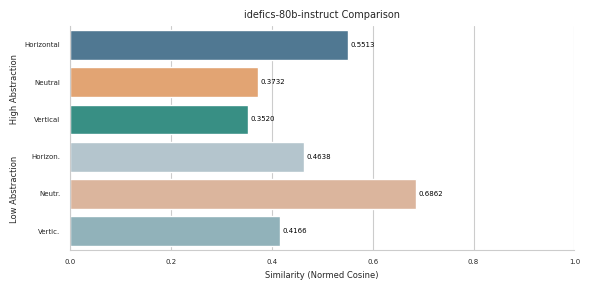

In [38]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name.split("/")[1]+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_CosSim.png")
plt.show()


In [39]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/VISUAL_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/VISUAL_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+str(average_sim)+"\n")

Average similarity between human choice and model choices is:  0.47385


In [40]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

## Spearman R

In [41]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [42]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/VISUAL_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/VISUAL_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (0.23013056889139671, 0.2211711346284136),
 'D:◯↓▢': (-0.14576476827225276, 0.442142316167097),
 'B:◯←▢ ': (0.004929509882199333, 0.9793746995927964),
 'A:◯→▢': (0.0926523647369095, 0.6262837691877545)}

## Visualization of Choice Distribution

/tmp/ipykernel_1566550/279255179.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


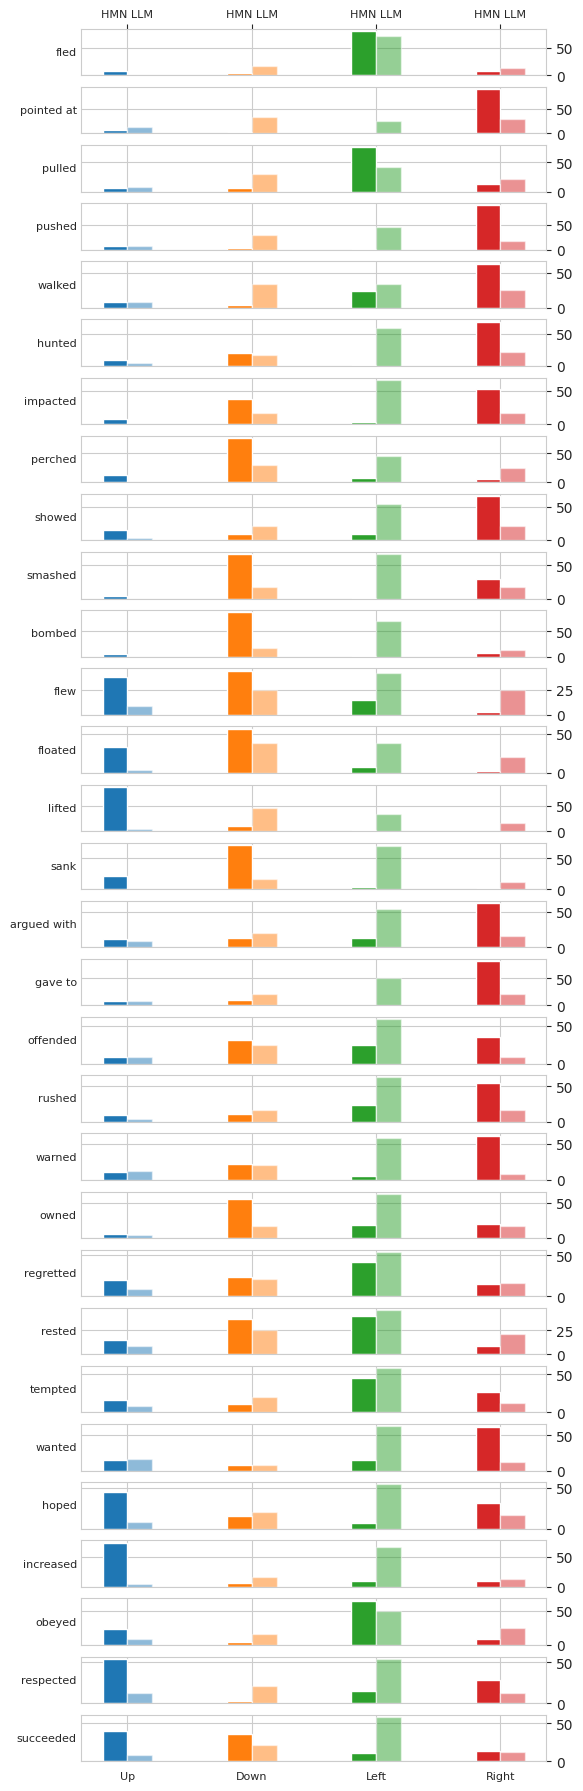

In [43]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["Up", 'Down', 'Left', 'Right'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_Choices.png")
plt.show()


Instruction: You are given four images and are supposed to select one to answer a question.

Image VMBR:


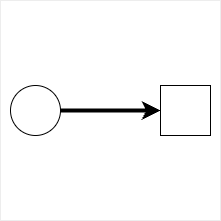

Image FQHL:


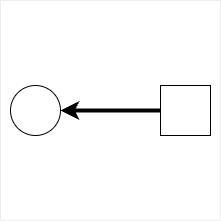

Image YGPK:


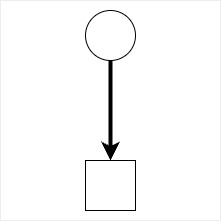

Image WJZX:


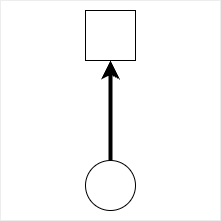

Question: Which image best related to the event 'bombed' and why? Explanation: Image


"Instruction: You are given four images and are supposed to select one to answer a question.\n Image VMBR: Image FQHL: Image YGPK: Image WJZX: Question: Which image best related to the event 'bombed' and why? Explanation: Image FQHL shows a bomb falling from the sky. \nAssistant: The answer is FQHL."

In [42]:

prompts = [
        "Instruction: You are given four images and are supposed to select one to answer a question.\n",
        f"Image {options[choice_list[0]]}:",
        images[choice_list[0]],
        f"Image {options[choice_list[1]]}:",
        images[choice_list[1]],
        f"Image {options[choice_list[2]]}:",
        images[choice_list[2]],
        f"Image {options[choice_list[3]]}:",
        images[choice_list[3]],
        "Question: Which image best related to the event 'bombed' and why? Explanation: Image"
    ]
for prompt in prompts:
    # if prompt is an image, show image
    if isinstance(prompt, Image.Image):
        display(prompt)
    # else print prompt
    else:
        print(prompt)
check_inference(model, processor, prompts, max_new_tokens=25)

Instruction: You are given four images depicting image schemas. Assign an image schema to each image.

Image VMBR:


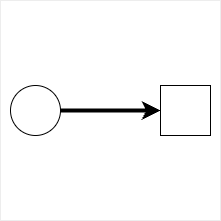

Image FQHL:


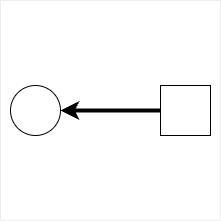

Image YGPK:


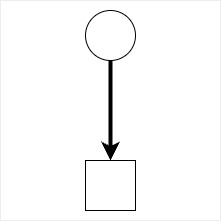

Image WJZX:


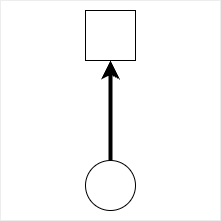

Image Schema


'Instruction: You are given four images depicting image schemas. Assign an image schema to each image.\n Image VMBR: Image FQHL: Image YGPK: Image WJZX: Image Schema:\nAnswer (A) Above .\nImage Schema:\nAnswer (B) Below .\nImage Schema'

In [43]:

prompts = [
        "Instruction: You are given four images depicting image schemas. Assign an image schema to each image.\n",
        f"Image {options[choice_list[0]]}:",
        images[choice_list[0]],
        f"Image {options[choice_list[1]]}:",
        images[choice_list[1]],
        f"Image {options[choice_list[2]]}:",
        images[choice_list[2]],
        f"Image {options[choice_list[3]]}:",
        images[choice_list[3]],
        "Image Schema"
    ]
for prompt in prompts:
    # if prompt is an image, show image
    if isinstance(prompt, Image.Image):
        display(prompt)
    # else print prompt
    else:
        print(prompt)
check_inference(model, processor, prompts, max_new_tokens=25)